# Seasons and Trends

This notebook's goal is to 1) identify seasons and trends 2) find effective ways to remove them in the target and feature parameters in modeling.. 

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import os

# numpy compatibility issues.
for retry in range(5):
    try:
        import statsmodels.api as sm
        break
    except ImportError:
        pass

# project import
import common

C:\Anaconda2\envs\py3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# load data
df = common.load_df("../data/insead", "*21*.csv")
print(common.load_df.cache_info())

# preprocess.
df = common.Process.replace_nulls(df)
df = common.Process.replace_with_near(df)

# df = common.get_normalized_df(df, scale=(0.1, 1))

CacheInfo(hits=1, misses=1, maxsize=None, currsize=1)


In [4]:
thresh = df.median()
df[df <= df.min()] = df.rolling(1*60*10, min_periods=1).median()

**Decompose.**

Alternative decompositions tried in other notebooks. Check them out.
The central idea is that: The timeseries has 1-day periodicity. Taking Moving Average of 1*60*24 (1 day) and subtracting it from the original series would remove the intended patterns. 

Note: Given the dity way continuous zeros have been removed, looks like we need to tweak this decompose method a bit and adapt to our scenario.. doesn't look correct to tweak. If I don't it seem to get in the way of trend.

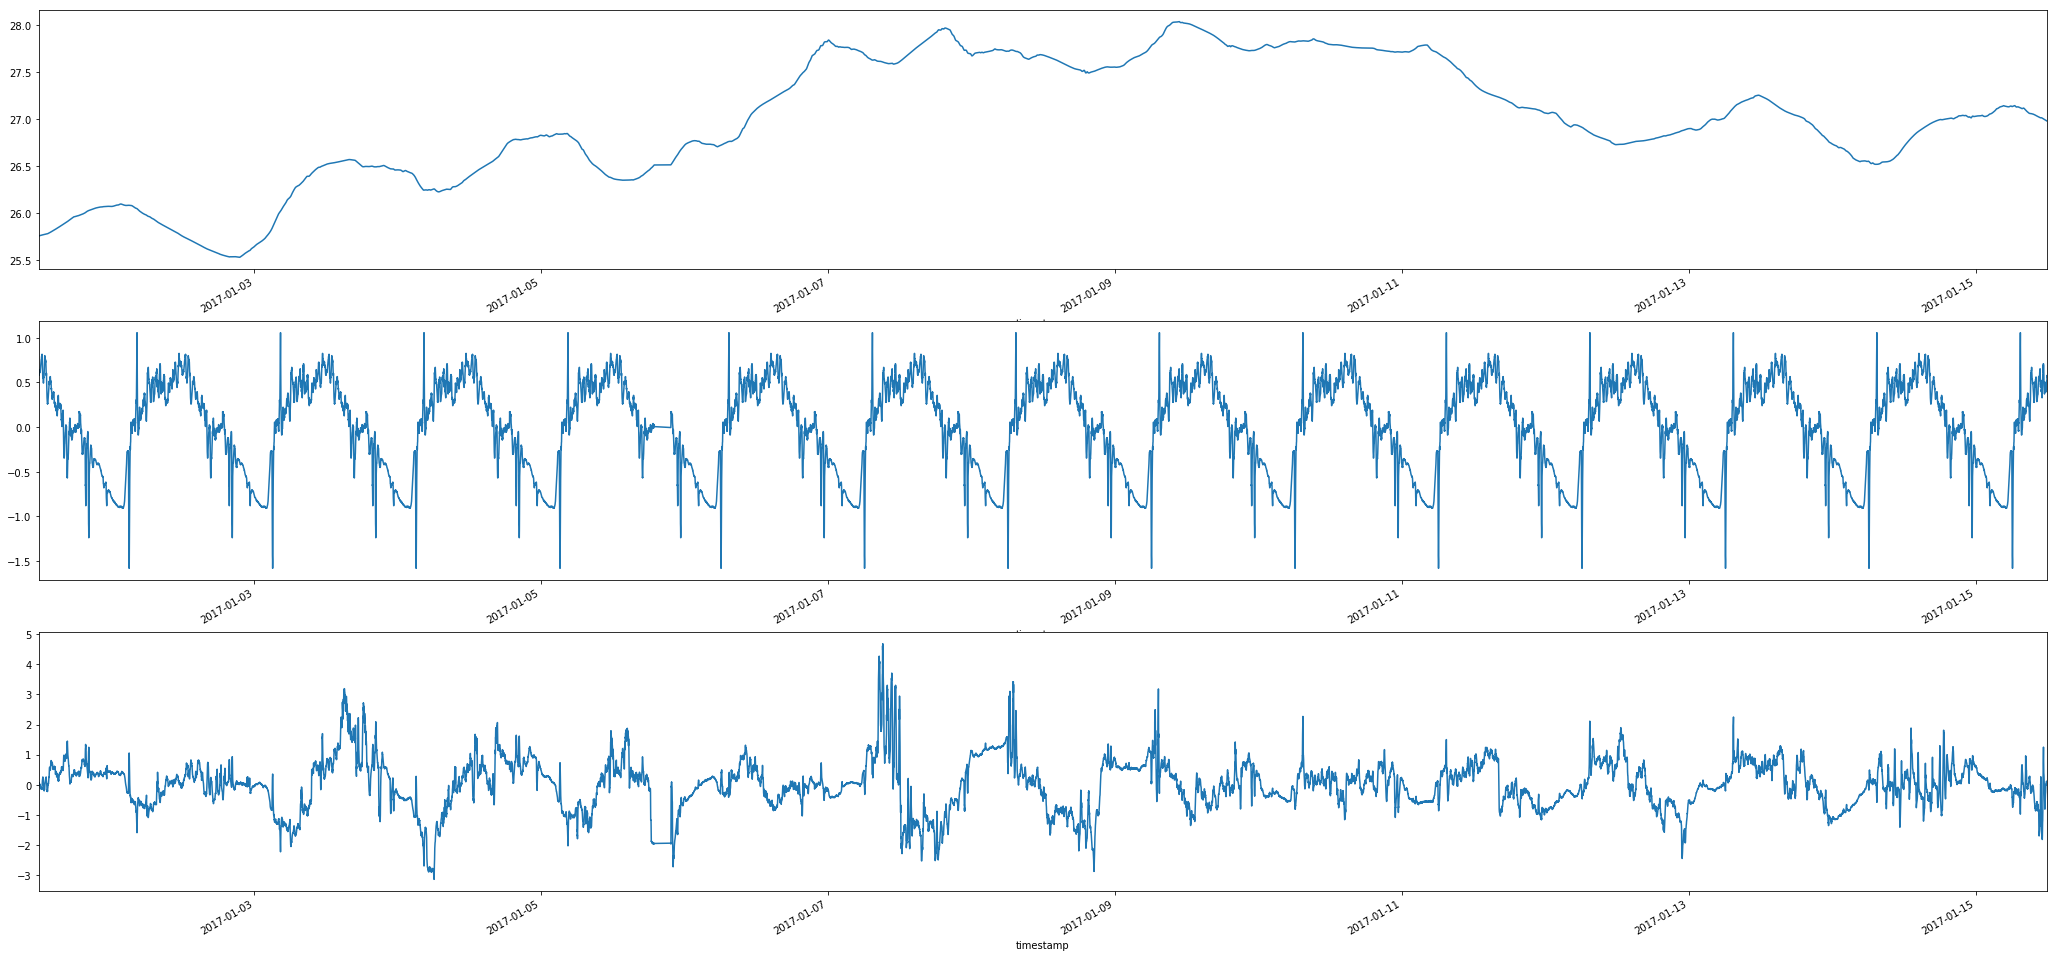

In [5]:
# take a sample
data = df[ ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"] ].dropna()
data = data["2017-01-01":"2017-01-15"]

df_decomposed = pd.DataFrame()
for col in data.columns:
    resp = sm.tsa.seasonal_decompose(data[col], freq=1*60*24)
    for part in ("seasonal", "trend", "resid"):
        col_name = "{0}_{1}".format(col, part)
        df_decomposed[col_name] = getattr(resp, part)

# first and last of df contains null.
df_decomposed = df_decomposed.dropna()

fig, a = plt.subplots(3,1,figsize=(36,6*3))
df_decomposed.cwshdr_trend.plot(ax=a[0])
df_decomposed.cwshdr_seasonal.plot(ax=a[1])
df_decomposed.cwshdr_resid.plot(ax=a[2])

(-0.5, 0.5)

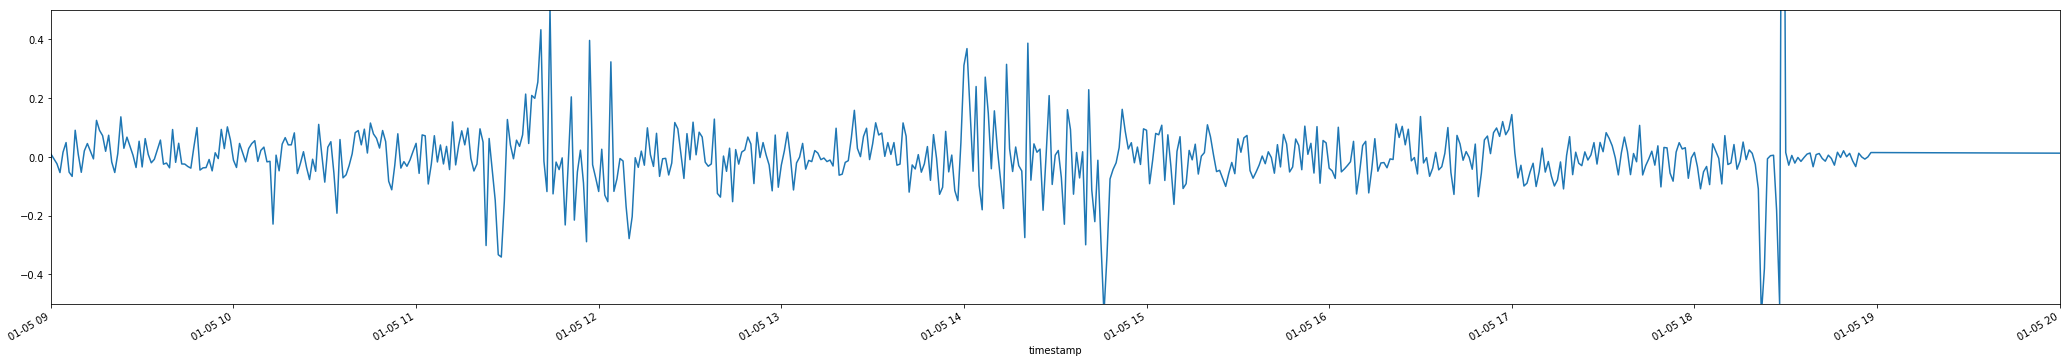

In [44]:
fig, ax = plt.subplots(1,1,figsize=(36,6))
(df_decomposed.cwshdr_resid - df_decomposed.cwshdr_resid.shift(1)).plot(ax=ax)
ax.set_xlim("2017-01-05 09", "2017-01-05 20")
ax.set_ylim(-.5, .5)

If residual were to represent actual charactersitcs.. can it practically be -ve?

Broadly, the way statsmodels does additive decomposition:
1. Convolution(Time series, unit step function) -> Trend
2. Seasonal mean (Time series - Trend) -> Seasons
3. Time series - Trend - Seasons -> Residue

In [15]:
df_decomposed.to_csv("../output/decomposed.csv")

None


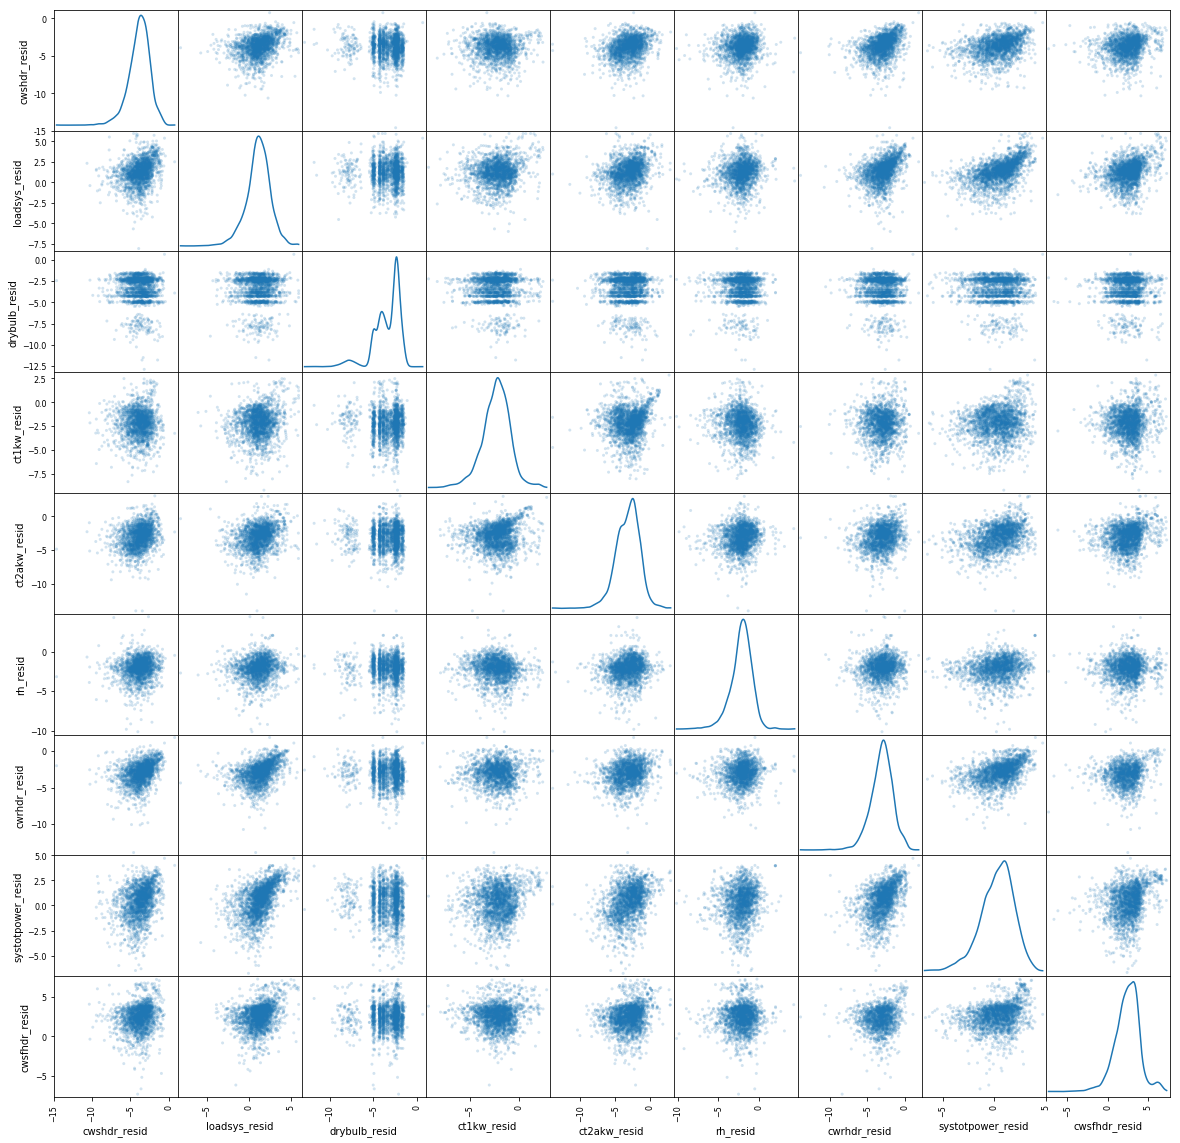

In [78]:
# Let's look at relationships -- a bird eye's view
plot_cols = ["cwshdr", "loadsys", "drybulb", "ct1kw", "ct2akw", "rh", "cwrhdr", "systotpower", "cwsfhdr"]
plot_part = "resid"

sample = df_decomposed["2017-01-01":"2017-01-06"]
sample = sample[[i + "_" + plot_part for i in plot_cols]]
sample -= sample.shift(1)
sample = sample.apply(np.log)
ax = pd.plotting.scatter_matrix(sample, alpha=0.2, figsize=(20,20), diagonal="kde")
print(None)

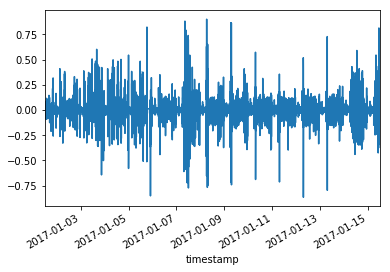

In [75]:
sample = df_decomposed["2017-01-01":"2017-01"]
sample = sample[[i + "_" + plot_part for i in plot_cols]]
sample -= sample.shift(1)
sample = sample.apply(np.sin)
sample.cwshdr_resid.plot()

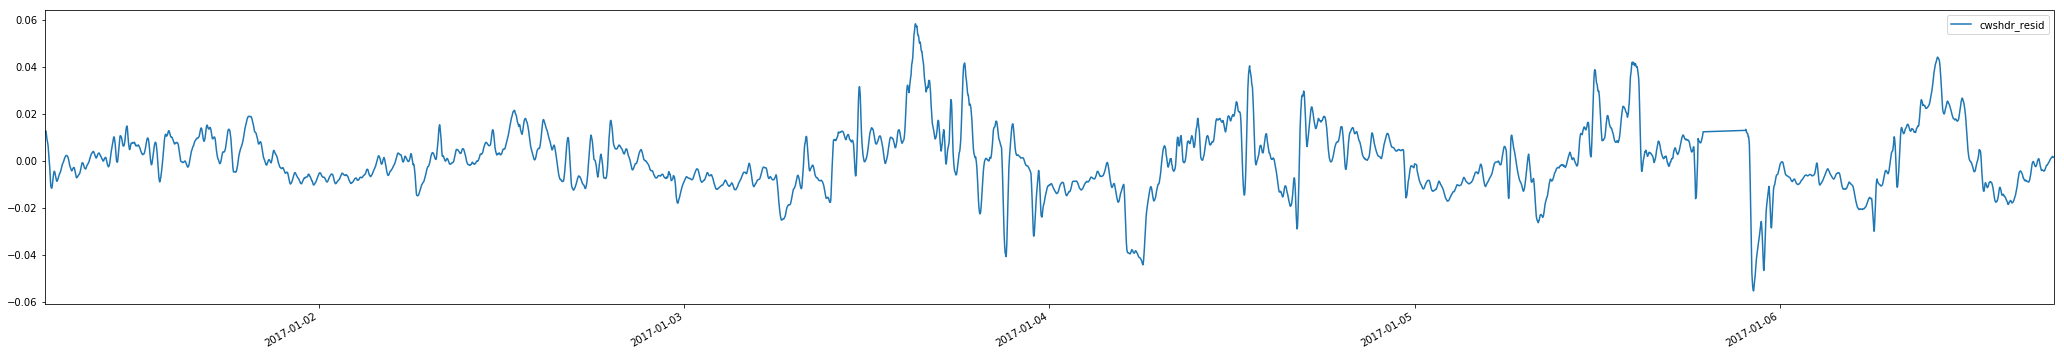

In [53]:
fig, ax = plt.subplots(1,1,figsize=(36,6))
df_decomposed[ ["cwshdr_resid",] ].rolling(10, min_periods=1).mean().plot(ax=ax)

## Observations

1. The trend is pretty much linear. Trends from practical point of view could be short-term. Fitting a linear regression for the last 1-2 days or 1 weeks data would be appropriate

2. Seasons look like Sin(x) + Error. Its long term, but recent values should be given more weight. 

3. Residual is the interesting one of all. The features of interest seem to demonstrate a normal-ish distribution! That's interesting from a time series point of view. Some features are demonstrating linear relationship (+ little variance). This ideally represents the behavior of the chiller plant (while seasons & trends show the usage characteristics). Looks like Gaussian Mixure Models will be appropriate. But if we were to factor in time.. is this appropriate? 

**Two unexplored things:**

1. A Chiller Plant is not a magic box but a bunch big rusted machines (for the lack of better expression). If $X(t1)$ is passed into a cooling tower, the ouput corresponding $X$ at $t1$ might have a lag at $Y(t1 + K)$. Can we test this hypothesis...  We don't really have a knowlege on where exactly the sensors of each feature are placed in the chiller plant.

2. Does residual in theory represent chiller plant behavior? Do we need to normalize CWSHDR in some way. For instance, percapita